1. Setup


1.1 Install dependencies

In [2]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

1.2 import dependencies

In [3]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

1.3 Set GPU growth

In [4]:
#Avoid OOM errors by setting gpu consumption limit
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

1.4 Create folder structure

In [5]:
# setup paths
POS_PATH= os.path.join('data','positive')
NEG_PATH= os.path.join('data','negative')
ANC_PATH= os.path.join('data','anchor')

In [6]:
#make directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

2.Collecting data

collect face database

In [7]:
#http://vis-www.cs.umass.edu/lfw

In [8]:
#uncompress the face data
#!tar -xf lfw.tgz

In [9]:
# #move images into negative file data
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw',directory)):
#         EX_PATH = os.path.join('lfw',directory,file)
#         NEW_PATH = os.path.join(NEG_PATH,file)
#         os.replace(EX_PATH,NEW_PATH)

2. Collect positive and anchor cases

In [10]:
#import uuid to generate unique image names
import uuid

In [11]:
# #establish a connection to webcam
# cap= cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()

#     #cut down frame
#     frame = frame[120:120+250,200:200+250,:]

#     #collect anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname,frame)
        
#     #collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname,frame)
        
#     #show image on screen
#     cv2.imshow('Image Collection',frame)

#     #breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
# #release the webcam
# cap.release()
# cv2.destroyAllWindows()

3.Load and preprocess

3.1 Get image directories

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

3.2 preprocess

In [13]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

3.3 Create labelled dataset

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

3.4 Create train and test partitions

In [15]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [16]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [17]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. Model engineering

4.1 Build embedding layer

In [19]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input image')

    #first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #second block
    c2 = Conv2D(128, (7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2),padding='same')(c2)

    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2),padding='same')(c3)

    #final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [20]:
embedding = make_embedding()

In [21]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

4.2 Make a distance layer

In [22]:
#building custom layer
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    #where it happens
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


4.3 Make siamese model

In [23]:
def make_siamese_model():
    #handle inputs
    input_image = Input(name='input image', shape=(100,100,3))
    validation_image = Input(name='validation_image',shape=(100,100,3))

    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))

    #classification layer
    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier,name='SiameseNetwork')


In [24]:
siamese_model = make_siamese_model()

In [25]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

5. Train the neural network

5.1 Setup loss function

In [26]:
#Network tries to minimise the loss function
#Get loss function from tensorflow
binary_cross_loss = tf.losses.BinaryCrossentropy()

5.1.2 Define the optimiser

In [27]:
#Define optimiser
opt = tf.keras.optimizers.Adam(1e-4)

5.2 Establish checkpoints

In [28]:
#setup checkpoint directory
checkpoint_dir = './training_checkpoints'

#create prefix for each checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')

#create checkpoint
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)


5.3 Build a custom training step

In [29]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        #get anchor and validation image
        X = batch[:2]
        #get label
        y= batch[2]

        #forward pass
        yhat = siamese_model(X, training=True)
        #calculate loss
        loss = binary_cross_loss(y,yhat)

    
    
    #calculate gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)

    #calculate updated weights and apply
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))

    

    

5.4 Define a training loop

In [30]:
def train(data,EPOCHS):
    #loop through the epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        #loop through each batch
        for idx,batch in enumerate(data):
            #run train step
            train_step(batch)
            progbar.update(idx+1)

        #save checkpoints
        if epoch%10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    


5.5 Train the model

In [31]:
EPOCHS = 50

In [32]:
#train(train_data,EPOCHS)

In [33]:
#save model
#siamese_model.save('siamesemodel.h5')

In [46]:
#reload model
trainedModel = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

6. Evaluate model

6.1 import metrics

In [35]:
#import metrics
from tensorflow.keras.metrics import Precision, Recall

6.2 Get testing data

In [36]:
#grab a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

6.3 Make predictions

In [37]:
#make predictions
y_hat = trainedModel.predict([test_input,test_val])
y_hat

array([[4.1362751e-12],
       [1.0000000e+00],
       [2.4054561e-10],
       [9.9131215e-01],
       [9.9999982e-01],
       [5.6706622e-11],
       [1.0000000e+00],
       [9.9999833e-01],
       [9.9999976e-01],
       [1.0000000e+00],
       [4.4307460e-10],
       [1.0000000e+00],
       [3.9455609e-11],
       [1.0000000e+00],
       [2.4326078e-11],
       [5.4619113e-13]], dtype=float32)

In [38]:
#postprocessing predictions
[1 if pred > 0.5 else 0 for pred in y_hat]

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]

6.4 Evaluate metrics

In [39]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [40]:
#use metrics
m = Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

6.5 Visualise results

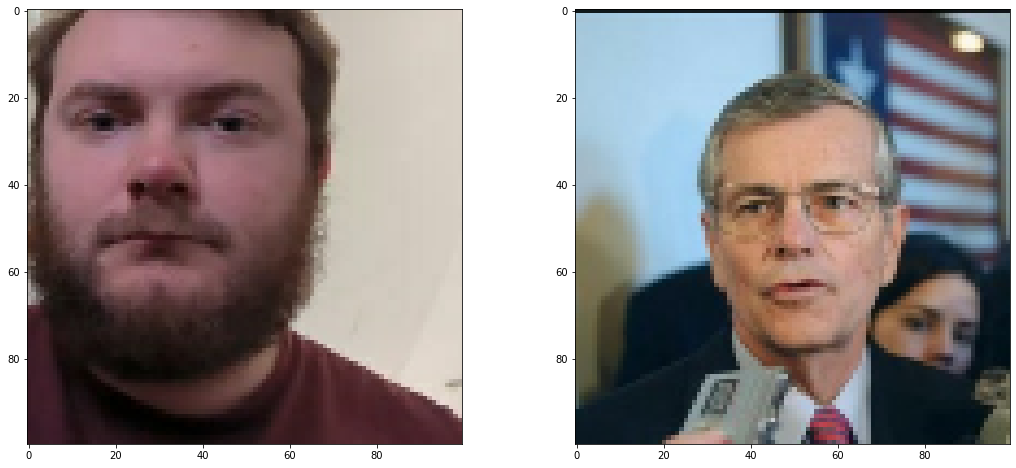

In [41]:
#set plot size
plt.figure(figsize=(18,8))

#set first subplot
plt.subplot(1,2,1) #no.rows,no.cols,index
plt.imshow(test_input[2])

#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

7. Perform real time predictions

7.1 Define verification function

In [48]:
def verify(model, detection_threshold, verification_threshold):
    

    #detection threshold: Metric above which a prediction is considered positive
    #verification threshold: number of positive matches with validation images

    #build results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_image = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_image = preprocess(os.path.join('application_data','verification_images',image))

        result = model.predict(list(np.expand_dims([input_image,validation_image],axis=1)))
        results.append(result)


    #how many above detection threshold
    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    #is above verification threshold?
    verified = verification > verification_threshold

    return results, verified

In [51]:
results, verified = verify(trainedModel,0.9,0.7)
verified


False

7.2 OpenCV real time predictions

In [53]:
#standard computer vision loop to test

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #cut down frame play around with values to get self in frame
    frame = frame[120:120+250,200:200+250,:]

    cv2.imshow('Verification', frame)

    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to input image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)

        #perform veification
        results, verified = verify(trainedModel,0.9,0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False
